# Insider Trading and Stock Volatility in Chinese A-Shares

Written by David Cai, Stern Undergraduate

Caution: File sizes are quite large and this program takes a lot of time to run. 

## Abstract

In this project, I study the effects that insider trading announcements have on individual stock volatility in Chinese A-shares. The period of my analysis is from January 1, 2004 to July 31, 2016. I follow the methodology in Muslumov (2008) and construct pre-announcement, announcement, and post-announcement windows. I begin by calculating unconditional volatilities for the announcement windows, without controlling for stock market volatility. I then calculate the conditional volatilities by controlling for stock market volatility. 

## Data Access
Data was accessed through Wind Financial Terminal at NYU Stern. The first dataset is all insider trade disclosures from January 1, 2004 to July 31, 2016 for all Chinese A-shares. The dataset is obtained as follows:

Wind -> Stock -> SSE & SZSE Market Statistics -> Company Research -> Momentous Shareholders -> Important Shareholders’ Trading in Secondary Market -> A-shares

The second data set is from stock price data from January 1, 2004 to July 31, 2016 for all Chinese A-shares. The third dataset is price data for the Shenzhen, Shanghai, and CSI 300 stock indexes from January 1, 2004 to July 31, 2016.  The second and third datasets are provided by Shuna Sun from the Volatility Institute at NYU Shanghai (VINS) through VINS internal data access software using information from Wind Financial Terminal.

## Data Cleaning

I remove observations where trading is suspended, as it is impossible to calculate a volatility when trading is suspended. I deal with outliers by applying the Winsorization statistical transformation. In China, there is a price limit for stock returns of +10% or -10%. The initial return for IPO stocks often exceeds 10%. I correct this by replacing values more extreme than +/-10% with +/-10%. 

In [3]:
import pandas as pd
file = '/Users/davidcai/Python/Projects/Data Bootcamp/return_status_eng.txt'
df = pd.read_csv(file)

In [7]:
df2 = df[df.trade_status != 'Suspended'] #Remove all entries where trading is suspended
df2[df2['pct_chg'] > 10] = 10
df2[df2['pct_chg'] < -10] = -10
df.to_csv(path_or_buf='/Users/davidcai/Python/Projects/Data Bootcamp/return_status_winsorized.txt', index=False)

/Users/davidcai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/davidcai/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/davidcai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Unconditional Volatility Calculation

The unconditional volatilities in the announcement windows are calculating following Chiyachantana et al. (2006). 

In [8]:
from pandas import np
from datetime import date

file1 = '/Users/davidcai/Python/Projects/Data Bootcamp/all_insider_concise.txt'
file2 = '/Users/davidcai/Python/Projects/Data Bootcamp/return_status_winsorized.txt'

insider = pd.read_csv(file1)

returns = pd.read_csv(file2)
returns["trade_date"] =  pd.to_datetime(returns["trade_date"])
returns.ix[returns.trade_status=='Suspended', 'close'] = np.nan #Do not calculate volatility if trading is suspended

#Create empty dictionary to store dataframes. Each insider trade will have its own dataframe of daily returns
d = {}

print(len(returns['asset_id'].unique())) #Print number of unique securities

for security in returns['asset_id'].unique():
    print(security) #Print current security (progress monitor)
    security_index = returns.asset_id == security #Search returns data for relevant security
    df1 = returns.loc[security_index]
    df1.is_copy = False #Bypass copy error message
    
    #Volatility calculation steps
    df1['close_pre']=df1['close'].shift(1)
    df1['close_wins']=df1['close_pre']*(1+(df1['pct_chg']/100))
    df1['log_close_pre']=np.log(df1['close_pre'])
    df1['log_close_wins']=np.log(df1['close_wins'])
    df1['log_diff']=df1['log_close_wins']-df1['log_close_pre']
    df1['log_diff_sqr']=df1['log_diff']**2
    
    #Calculate volatilities for windows
    df1['vol_ann5']=df1['log_diff_sqr'].rolling(window=5,center=True).mean() #announcement, from -2 to +2
    df1['vol_pre3']=df1['log_diff_sqr'].rolling(window=3).mean().shift(3) #pre-announcement, from -3 to -5
    df1['vol_pre13']=df1['log_diff_sqr'].rolling(window=13).mean().shift(3) #pre-announcement, from -3 to -15
    df1['vol_pre23']=df1['log_diff_sqr'].rolling(window=23).mean().shift(3) #pre-announcement, from -3 to -25
    df1['vol_pre48']=df1['log_diff_sqr'].rolling(window=48).mean().shift(3) #pre-announcement, from -3 to -50
    df1['vol_post3']=df1['log_diff_sqr'].rolling(window=3).mean().shift(-5) #post-announcement, from +3 to +5
    df1['vol_post13']=df1['log_diff_sqr'].rolling(window=13).mean().shift(-15) #post-announcement, from +3 to +15
    df1['vol_post23']=df1['log_diff_sqr'].rolling(window=23).mean().shift(-25) #post-announcement, from +3 to +25
    df1['vol_post48']=df1['log_diff_sqr'].rolling(window=48).mean().shift(-50) #post-announcement, from +3 to +50
    
    d[security] = df1 #Copy dataframe
    d[security].is_copy = False #Bypass copy error message

data_cols = ['asset_id','report_date','vol_ann5','vol_pre3','vol_pre13','vol_pre23','vol_pre48','vol_post3',
             'vol_post13','vol_post23','vol_post48']

vol_data = pd.DataFrame(columns=data_cols)

for security in returns['asset_id'].unique(): 
    df_insider = insider[insider['asset_id'] == security]
    for date in df_insider['report_date'].unique():
        df2 = d[security]
        df2.is_copy = False
        new_row = pd.DataFrame(columns=data_cols)
        new_row[data_cols] = df2[df2['trade_date'] == date][['asset_id','trade_date','vol_ann5','vol_pre3','vol_pre13',
                                                             'vol_pre23','vol_pre48','vol_post3','vol_post13',
                                                             'vol_post23','vol_post48']]
        vol_data = vol_data.append(new_row,ignore_index=True)

vol_data = vol_data.dropna() #Drop all rows with empty values
vol_data.to_csv(path_or_buf='/Users/davidcai/Python/Projects/Data Bootcamp/output/uncond_windows.csv',index=False)

2816
000001.SZ
000157.SZ
000002.SZ
000004.SZ
000017.SZ
000005.SZ
000006.SZ
000007.SZ
000008.SZ
000009.SZ
000010.SZ
000011.SZ
000012.SZ
000014.SZ
000016.SZ
000018.SZ
000019.SZ
000021.SZ
000020.SZ
000022.SZ
000023.SZ
000025.SZ
000026.SZ
000033.SZ
000027.SZ
000029.SZ
000028.SZ
000030.SZ
000031.SZ
000032.SZ
000034.SZ
000036.SZ
000035.SZ
000037.SZ
000038.SZ
000039.SZ
000043.SZ
000050.SZ
000045.SZ
000040.SZ
000042.SZ
000046.SZ
000048.SZ
000049.SZ
000055.SZ
000056.SZ
000058.SZ
000059.SZ
000060.SZ
000061.SZ
000062.SZ
000066.SZ
000150.SZ
000063.SZ
000065.SZ
000068.SZ
000069.SZ
000090.SZ
000070.SZ
000078.SZ
000155.SZ
000088.SZ
000089.SZ
000096.SZ
000099.SZ
000100.SZ
000151.SZ
000153.SZ
000156.SZ
000158.SZ
000159.SZ
000301.SZ
000400.SZ
000401.SZ
000402.SZ
000403.SZ
000408.SZ
000417.SZ
000498.SZ
000561.SZ
000404.SZ
000407.SZ
000409.SZ
000410.SZ
000411.SZ
000413.SZ
000415.SZ
000416.SZ
000418.SZ
000419.SZ
000420.SZ
000421.SZ
000422.SZ
000423.SZ
000425.SZ
000426.SZ
000428.SZ
000429.SZ
000430.SZ
00048

FileNotFoundError: [Errno 2] No such file or directory: '/Users/davidcai/Python/Projects/Data Bootcamp/Data/output/uncond_windows'

In [18]:
vol_data = pd.read_csv('/Users/davidcai/Python/Projects/Data Bootcamp/output/uncond_windows.csv')

In [19]:
vol_data = vol_data[['vol_pre48','vol_pre23','vol_pre13','vol_pre3','vol_ann5','vol_post3',
             'vol_post13','vol_post23','vol_post48']]
vol_data = vol_data.rename(columns={'vol_pre48':'(-50, -3)','vol_pre23':'(-25, -3)','vol_pre13':'(-15, -3)',
                                    'vol_pre3':'(-5, -3)','vol_ann5':'(-2, +2)','vol_post3':'(+3, +5)',
                                    'vol_post13':'(+3, +15)','vol_post23':'(+3, +25)','vol_post48':'(+3, +50)'
                                   })
vol_data = vol_data * 10000
vol_data.mean()

(-50, -3)    11.457247
(-25, -3)    11.935993
(-15, -3)    12.507862
(-5, -3)     13.541186
(-2, +2)     13.953783
(+3, +5)     12.043959
(+3, +15)    12.095510
(+3, +25)    12.089287
(+3, +50)    12.100402
dtype: float64

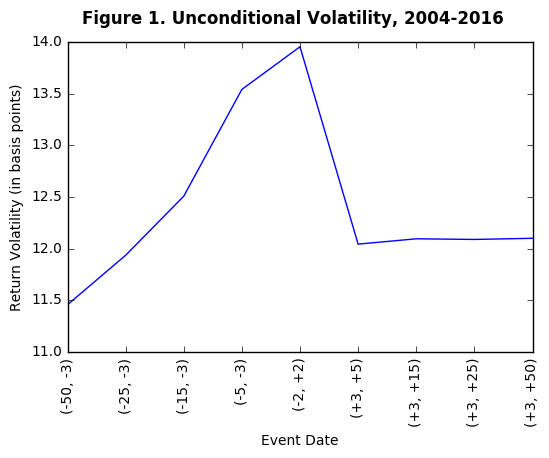

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
vol_data.mean().plot(kind='line', rot='vertical')
plt.suptitle('Figure 1. Unconditional Volatility, 2004-2016', fontsize=12, weight='bold')
plt.ylabel('Return Volatility (in basis points)')
plt.xlabel('Event Date')

### Unconditional Volatility Finding

Individual stock unconditional volatilities increase approaching the announcement date. The average daily unconditional volatily of Chinese A-shares begins at 11.46 basis points in the longest pre-announcement window from 50 days before the announcement date to three days before the announcement date (-50, -3). Stock volatilities gradually increase as the announcement window approaches. The volatility is highest in the announcement window (-2, +2) and peaks at 13.95 basis points. Stock volatilites decline following the announcement date, but persist higher than pre-announcement levels. The last post-annoucement window (+3, +50) has an unconditional volatility of 12.10 basis points, 0.64 basis points higher than the (-50, -3) pre-announcement window. 

## Conditional Volatility Calculation

The conditional volatilities in the announcement windows are calculating following Muslumov (2008). Since changes individual stock volatilities in the annoucement windows could be caused by market volatility, I calculate market-adjusted volatility. I use the CSI 300 Index, a  capitalization-weighted stock market index that replicates the performance of the Shanghai and Shenzhen stock exchanges. Since my data set has both Shanghai and Shenzhen stocks, I use the CSI 300 as a single control variable for convenience. 

In [23]:
import pandas as pd
from pandas import np
import datetime

file3 = '/Users/davidcai/Python/Projects/Data Bootcamp/output/uncond_windows.csv' #insider windows
file4 = '/Users/davidcai/Python/Projects/Data Bootcamp/CSI_windows.csv' #index windows

insider = pd.read_csv(file3)
market = pd.read_csv(file4)

insider["report_date"] =  pd.to_datetime(insider["report_date"])
market["trade_date"] =  pd.to_datetime(market["trade_date"])

data_cols = ['asset_id','report_date','vol_ann5','vol_pre3','vol_pre13','vol_pre23','vol_pre48','vol_post3',
             'vol_post13','vol_post23','vol_post48']

cond_data = pd.DataFrame(columns=data_cols)

for security in insider['asset_id'].unique():
    print(security) #Print current security (progress monitor)
    df1 = insider[insider['asset_id'] == security]
    df2 = df1.set_index(['asset_id','report_date'])
    df3 = market[market['trade_date'].isin(df1['report_date']) ]
    df3 = df3.rename(columns={'trade_date':'report_date'}).set_index(['report_date'])
    df3 = df3.drop(['asset_id'], axis=1)
    df2 = df2.sub(df3)
    df2 = df2.reset_index()
    
    cond_data = cond_data.append(df2,ignore_index=True)

cond_data

cond_data = cond_data.dropna() #Drop all rows with empty values
cond_data.to_csv(path_or_buf='/Users/davidcai/Python/Projects/Data Bootcamp/output/cond_windows',index=False)

000001.SZ
000157.SZ
000002.SZ
000004.SZ
000017.SZ
000005.SZ
000006.SZ
000007.SZ
000008.SZ
000009.SZ
000010.SZ
000011.SZ
000012.SZ
000014.SZ
000018.SZ
000019.SZ
000021.SZ
000022.SZ
000023.SZ
000025.SZ
000026.SZ
000033.SZ
000027.SZ
000029.SZ
000028.SZ
000030.SZ
000031.SZ
000032.SZ
000034.SZ
000036.SZ
000037.SZ
000039.SZ
000043.SZ
000050.SZ
000045.SZ
000040.SZ
000042.SZ
000046.SZ
000048.SZ
000049.SZ
000055.SZ
000056.SZ
000058.SZ
000059.SZ
000060.SZ
000061.SZ
000062.SZ
000066.SZ
000150.SZ
000063.SZ
000065.SZ
000068.SZ
000069.SZ
000090.SZ
000070.SZ
000078.SZ
000155.SZ
000088.SZ
000089.SZ
000096.SZ
000099.SZ
000100.SZ
000151.SZ
000153.SZ
000158.SZ
000159.SZ
000301.SZ
000400.SZ
000401.SZ
000402.SZ
000408.SZ
000417.SZ
000561.SZ
000404.SZ
000407.SZ
000409.SZ
000410.SZ
000411.SZ
000413.SZ
000416.SZ
000418.SZ
000419.SZ
000420.SZ
000421.SZ
000422.SZ
000423.SZ
000425.SZ
000426.SZ
000428.SZ
000429.SZ
000488.SZ
000501.SZ
000502.SZ
000503.SZ
000506.SZ
000530.SZ
000505.SZ
000507.SZ
000509.SZ
000510.SZ


In [24]:
cond_data = cond_data[['vol_pre48','vol_pre23','vol_pre13','vol_pre3','vol_ann5','vol_post3',
             'vol_post13','vol_post23','vol_post48']]
cond_data = cond_data.rename(columns={'vol_pre48':'(-50, -3)','vol_pre23':'(-25, -3)','vol_pre13':'(-15, -3)',
                                    'vol_pre3':'(-5, -3)','vol_ann5':'(-2, +2)','vol_post3':'(+3, +5)',
                                    'vol_post13':'(+3, +15)','vol_post23':'(+3, +25)','vol_post48':'(+3, +50)'
                                   })
cond_data = cond_data * 10000
cond_data.mean()

(-50, -3)     8.192155
(-25, -3)     8.672374
(-15, -3)     9.176001
(-5, -3)     10.134768
(-2, +2)     10.638404
(+3, +5)      8.950198
(+3, +15)     8.806153
(+3, +25)     8.720173
(+3, +50)     8.674891
dtype: float64

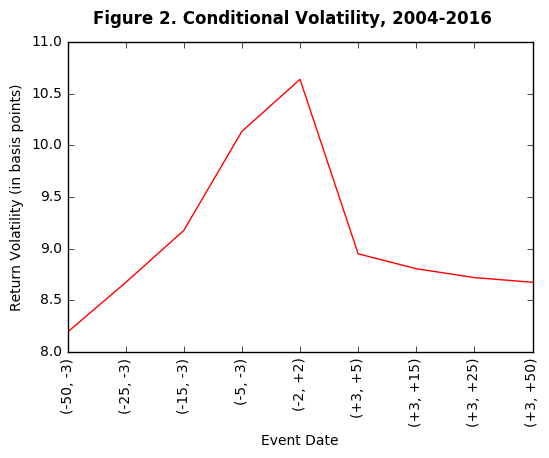

In [31]:
cond_data.mean().plot(kind='line', rot='vertical', color='r')
plt.suptitle('Figure 2. Conditional Volatility, 2004-2016', fontsize=12, weight='bold')
plt.ylabel('Return Volatility (in basis points)')
plt.xlabel('Event Date')

### Conditional Volatility Finding

My finding persists even after controlling for stock market volatility. Individual market-adjusted volatilities also increase approaching the announcement date. 

The average daily conditional volatily of Chinese A-shares begins at 8.19 basis points in the longest pre-announcement window from 50 days before the announcement date to three days before the announcement date (-50, -3). Stock volatilities gradually increase as the announcement window approaches. The volatility is highest in the announcement window (-2, +2) and peaks at 10.64 basis points. Stock volatilites decline following the announcement date, but persist higher than pre-announcement levels. The last post-annoucement window (+3, +50) has an unconditional volatility of 8.67 basis points, 0.48 basis points higher than the (-50, -3) pre-announcement window.

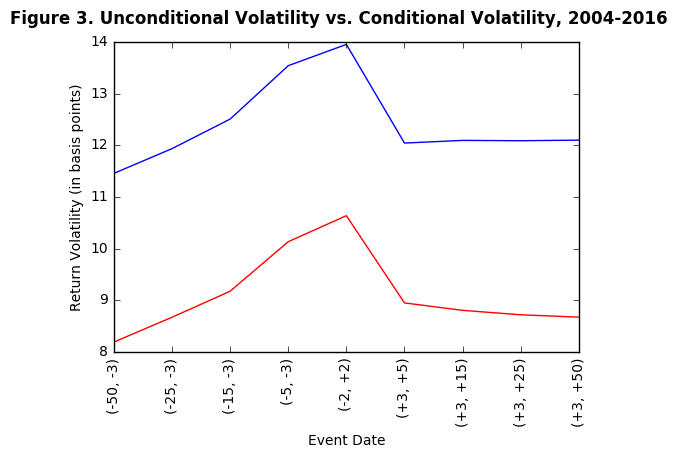

In [33]:
vol_data.mean().plot(kind='line', rot='vertical', color='b')
cond_data.mean().plot(kind='line', rot='vertical', color='r')
plt.suptitle('Figure 3. Unconditional Volatility vs. Conditional Volatility, 2004-2016', fontsize=12, weight='bold')
plt.ylabel('Return Volatility (in basis points)')
plt.xlabel('Event Date')

### Figure 3

Figure 3 shows that stocks with insider trading announcements exhibit the same behavior even after controlling for stock-market volatility. The amount of individual stock volatility attributable to market volatility ranges between 3.09 to 3.41 basis points. Market-adjusted volatility increases approaching the announcement date and declines following it. Post-announcement volatilities persist above pre-announcement levels. 

In [34]:
vol_data.mean() - cond_data.mean()

(-50, -3)    3.265092
(-25, -3)    3.263619
(-15, -3)    3.331862
(-5, -3)     3.406418
(-2, +2)     3.315378
(+3, +5)     3.093761
(+3, +15)    3.289356
(+3, +25)    3.369114
(+3, +50)    3.425510
dtype: float64

## Conclusion

My preliminary analysis indicates that insider trading announcements for Chinese A-shares contribute to higher levels of volatility in these stocks, especially close to the announcement date. One possible explaination is that investors fear insiders trading on insider information, a widely documented phenomenon in the Chinese stock market, which leads to higher volatilities. 

In my study, I found that average stock volatilities were lowest in the longest pre-announcement window and increased nearing the announcement window, where it peaked. Volatilities declined following the announcement date, but persisted higher than pre-announcement levels. 

More work is needed in this analysis. A statistical analysis is needed to determine whether there are statistically significant differences betweeen stocks with insider trading activity and stocks without. Moreover, robustness checks are needed. 

## References

Muslumov, A. (2008). The Effects of Insider Trading on the Stock Price Volatility in an Emerging Market Setting: Evidence from Istanbul Stock Exchange.

Chiyachantana, C. N., Jain, P. K., Jiang, C., & Wood, R. A. (2006). Volatility effects of institutional trading in foreign stocks. Journal of Banking & Finance, 30(8), 2199-2214.